In [1]:
import keras.callbacks
import tensorflow_decision_forests as tfdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import keras_tuner as kt
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

2022-07-25 18:24:12.519918: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-25 18:24:12.526585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 18:24:12.526612: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
class RF:

    def __init__(self, data, obs_col, class_col):
        self.data = data
        self.obs_col = obs_col
        self.class_col = class_col
        self.train_set = None
        self.test_set = None
        self.train_ds = None
        self.test_ds = None
        self.models = dict()
        self.class_weights = None

    def pre_process_data(self, standardize=True, normalize=False):
        if standardize:
            features = self.data.drop([self.obs_col, self.class_col], axis=1, errors="ignore")
            col_names = features.columns
            scaler = StandardScaler().fit(features.values)
            features = scaler.transform(features.values)
            self.data[col_names] = features
        elif normalize:
            pass


    def train_test_split(self, ratio=0.3):
        if self.data is not None:
            test_indices = np.random.rand(len(self.data)) < ratio
            self.train_set, self.test_set = self.data[~test_indices].drop(self.obs_col, axis=1), self.data[test_indices].drop(self.obs_col, axis=1)
            self.train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(self.train_set, label=self.class_col)
            self.test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(self.test_set, label=self.class_col)
        else:
            print("data not loaded")

        y_train = self.train_set["cell_type"]
        class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
        self.class_weights = dict(enumerate(class_weights))

    def add_new_model(self, model_name, model_type = "Random Forest", params=None):

        self.train_test_split()
        print("add_new_model:")
        if params:
            print("parameter supplied")
            if model_type == "Random Forest":
                print("Random Forest model...")
                model = tfdf.keras.RandomForestModel(**params)
                print(model.learner_params)
            elif model_type == "Gradient Boosted Trees":
                print("GBT model...")
                model = tfdf.keras.GradientBoostedTreesModel()
        else:

            print("no parameters supplied, using default model")

            if model_type == "Random Forest":
                print("default Random Forest model...")
                model = tfdf.keras.RandomForestModel()
            else:
                print( "default gradient boosted tree")
                model = tfdf.keras.GradientBoostedTreesModel()
        self.models.update({model_name: model})

    def tune_model(self, model_name, tuner, use_class_weights=True, model_type="RandomForest"):

        if model_type == "RandomForest":
            build_model = build_model_rf
        else:
            build_model = build_model_gbt

        print(self.class_weights)
        print(self.train_set)

        if tuner == "RandomSearch":
            print("RandomSearch optimizer")
            tuner = kt.RandomSearch(
            hypermodel = build_model,
            objective="val_accuracy",
            max_trials=20,
            executions_per_trial=1,
            overwrite=True,
            directory="../results/",
            project_name=f"{model_name}_{model_type}_tuned"
        )
        elif tuner == "Hyperband":
            print("Hyperband optimizer")
            tuner = kt.Hyperband(
                hypermodel = build_model,
                objective="val_accuracy",
                max_epochs=1,
                hyperband_iterations=10,
                overwrite=True,
                directory="../results/",
                project_name=f"{model_name}_{model_type}_hyperband_tuned"
            )
        elif tuner == "Bayesian":
            print("Bayesian optimizer")
            tuner = kt.BayesianOptimization(
                hypermodel=build_model,
                objective="val_accuracy",
                max_trials=20,
                overwrite=True,
                directory="../results/",
                project_name=f"{model_name}_{model_type}_bayesian_tuned"
            )

        tuner.search(self.train_ds,
                     validation_data=self.test_ds,
                     epochs=1,
                     callbacks=[keras.callbacks.EarlyStopping(patience=1),
                                keras.callbacks.TensorBoard(f"../results/Callbacks/{model_name}_{model_type}")],
                     class_weight=self.class_weights)




        print("Tuning done.")
        print("Best model: ")
        print(tuner.get_best_models(1)[0])
        print("Best hyperparameters: ")
        print(tuner.get_best_hyperparameters(1)[0])
        model = tuner.get_best_models(1)[0]
        model.fit(self.train_ds, verbose=0, class_weight=self.class_weights)
        prediction = model.predict(self.test_ds)
        prediction = pd.DataFrame(prediction)
        prediction.columns = ["hetero", "homo", "singlet"]
        prediction["prediction"] = prediction.apply(lambda row: self.class_checker(row), axis=1)
        self.models.update({model_name: {"model": model,
                                         "tuner": tuner,
                                         "prediction": prediction}})
        model.save(f"../models/{model_name}_{model_type}")
        prediction.to_csv(f"../models/{model_name}_{model_type}/prediction.csv")
        self.test_set.to_csv(f"../models/{model_name}_{model_type}/test_set.csv")

        print("------------------------")
        print(f"test class distribution: \n"
              f"{self.test_set['cell_type'].value_counts()}\n"
              f"\n"
              f"prediction class distribution:\n"
              f"{prediction['prediction'].value_counts()}")

        self.plot_cm(self.test_set["cell_type"], prediction["prediction"])

        print(model.summary())
        return None

        pass

    def train_model(self, model_name, use_class_weights=True, metrics="Accuracy", verbose=0):
        if model_name in self.models.keys():
            model = self.models[model_name]
            print(f"training model: {model_name}")
            model.fit(x=self.train_ds,  verbose=verbose, class_weight=self.class_weights)


            print("compiling model")
            model.compile(metrics=metrics)
        else:
            print("model not found.")


    def evaluate_model(self, model_name):
        model = self.models[model_name]
        evaluation = model.evaluate(self.test_ds, return_dict=True)
        print(evaluation)

    def predict(self, model_name, use_tuner):
        if use_tuner:
            model = self.models[model_name]["tuner"].get_best_models(1)[0]
        else:
            model = self.models[model_name]

        prediction = model.predict(self.test_ds)
        prediction = pd.DataFrame(prediction)
        prediction.columns = ["hetero", "homo", "singlet"]
        prediction["prediction"] = prediction.apply(lambda row: self.class_checker(row), axis=1)
        print(prediction)

        print("------------------------")
        print(f"test class distribution: \n"
              f"{self.test_set['cell_type'].value_counts()}\n"
              f"\n"
              f"prediction class distribution:\n"
              f"{prediction['prediction'].value_counts()}")

        self.plot_cm(self.test_set["cell_type"], prediction["prediction"])
        return None

    def class_checker(self, row):
        if row["homo"] > row["hetero"] and row["homo"] > row["singlet"]:
            return "homo"
        elif row["hetero"] > row["homo"] and row["hetero"] > row["singlet"]:
            return "hetero"
        else:
            return "singlet"

    def plot_cm(self, labels, predictions, p=0.5):
      cm = confusion_matrix(labels, predictions, labels=["hetero", "homo", "singlet"])
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix')
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

In [18]:
def build_model_rf(hp):
    model = tfdf.keras.RandomForestModel(
        num_trees=hp.Int("num_trees", min_value=300, max_value=1000, step=100),
        max_depth=hp.Int("max_depth", min_value=3, max_value=40, step=4),
        categorical_algorithm=hp.Choice("categorical_algorithm", ["CART", "RANDOM"]),
        num_candidate_attributes_ratio=hp.Float("num_candidate_attributes_ratio", min_value=0.2, max_value=0.99, step=0.1),
        min_examples=hp.Int("min_examples", min_value=2, max_value=24, step=2),
        growing_strategy="LOCAL",
        honest=hp.Boolean("honest"),
        winner_take_all=hp.Boolean("winner_take_all")
    )
    model.compile(metrics=[keras.metrics.AUC(multi_label=False)])
    return model

def build_model_gbt(hp):
    model = tfdf.keras.GradientBoostedTreesModel(
        max_depth=hp.Int("max_depth", min_value=4, max_value=40, step=4),
        # max_num_nodes=hp.Int("max_num_nodes", min_value=16, max_value=256, step=16),
        use_hessian_gain=hp.Boolean("use_hessian_gain", default=False),
        categorical_algorithm=hp.Choice("categorical_algorithm", ["CART", "RANDOM"]),
        shrinkage=hp.Float("shrinkage", min_value=0.02, max_value=0.2, step=0.02),
        num_candidate_attributes_ratio=hp.Float("num_candidate_attributes_ratio", min_value=0.2, max_value=0.99, step=0.1),
        min_examples=hp.Int("min_examples", min_value=2, max_value=10, step=1),
        growing_strategy="LOCAL",
        honest=True
    )
    model.compile(metrics=["accuracy"])
    return model




params_v1 = {
    "random_seed": 123456,
    "num_trees": 500,
    "categorical_algorithm": "CART",
    "compute_oob_performances": True,
    "growing_strategy": "LOCAL",
    "honest": False,
    "max_depth": 16,
    "max_num_nodes": None
}

params_v2 = {
    "random_seed": 123456,
    "num_trees": 500,
    "categorical_algorithm": "CART",
    "compute_oob_performances": True,
    "growing_strategy": "LOCAL",
    "honest": True,
    "max_depth": 32,
    "max_num_nodes": None
}

params_v3 = {
    "random_seed": 123456,
    "num_trees": 500,
    "categorical_algorithm": "RANDOm",
    "compute_oob_performances": True,
    "growing_strategy": "BEST_FIRST_GLOBAL",
    "honest": False,
    "max_depth": 16,
    "max_num_nodes": 1000
}

<AxesSubplot:ylabel='Frequency'>

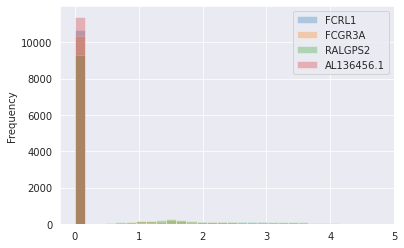

In [19]:
data = pd.read_csv("../data/processed/pbmc_hvg_12012_100.csv", index_col=0)
data
data.iloc[:, 1:5].plot.hist(bins=30, alpha=0.3)

In [23]:
data["cell_type"] = [0 if y == "singlet" else (1 if y == "hetero" else 2) for y in data["cell_type"]]

In [25]:
data["cell_type"].value_counts()

0    11196
1      455
2      361
Name: cell_type, dtype: int64

### Trying hyperparameter tuning
1. Load data

In [27]:
rf_models2 = RF(data, "obs", "cell_type")
rf_models2.pre_process_data(standardize=True)

### Pre-processing stuff

1. calculating the class weights

Random Forest

In [28]:
rf_models2.add_new_model("pbmc_hvg_100_test")
rf_models2.tune_model("pbmc_hvg_100_test", tuner="Bayesian", model_type="RandomForest")

add_new_model:
no parameters supplied, using default model
default Random Forest model...
Use /tmp/tmp9_bx1o41 as temporary training directory
{0: 0.3578088578088578, 1: 8.68867924528302, 2: 11.096385542168674}
         TGFBR3     FCRL1    FCGR3A   RALGPS2  AL136456.1      RHEX      RGS7  \
1     -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
2     -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
3     -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
9      3.517347 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
10    -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
...         ...       ...       ...       ...         ...       ...       ...   
12005 -0.385951 -0.334671 -0.367473 -0.480910    3.055804 -0.219187 -0.170432   
12006 -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0.219187 -0.170432   
12007 -0.385951 -0.334671 -0.367473 -0.480910   -0.209603 -0

/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
700               |?                 |num_trees
3                 |?                 |max_depth
RANDOM            |?                 |categorical_algorithm
0.8               |?                 |num_candidate_attributes_ratio
2                 |?                 |min_examples
True              |?                 |honest
True              |?                 |winner_take_all

Use /tmp/tmpnt0vnbur as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.587273. Found 8289 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(3723, shape=(), dtype=int32)
Validation dataset read in 0:00:00.953900. Found 3723 examples.
Training model...
Model trained in 0:00:01.915517
Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmpnt0vnbur/model/ with prefix 0fdf250ba8c94779
[INFO abstract_model.cc:1248] Engine "RandomForestGeneric" built
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


ValueError: in user code:

    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 802, in test_function  *
        return step_function_trained(self, iterator)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 784, in run_step  *
        outputs = model.test_step(data)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1502, in test_step  **
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/metrics/metrics.py", line 1759, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 619, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 3) and (None, 1) are incompatible


In [2]:
import keras

2022-07-24 23:27:22.895039: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-24 23:27:22.925431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-24 23:27:22.925447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
model = keras.models.load_model("/tmp/tmp7ljjrjvd/")

OSError: No file or directory found at /tmp/tmp7ljjrjvd/

In [21]:
rf_models2.test_set.to_csv("../models/main_rf_preprocessed_50_RandomForest/test_set.csv")

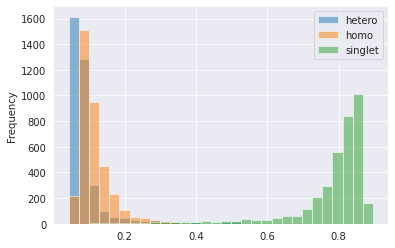

In [18]:
model = rf_models2.models["main_rf"]
homo = model["prediction"]
ax = homo.plot.hist(bins=30, alpha=0.5)

Gradient Boosted Trees

In [ ]:
rf_models2.add_new_model("main_rf_reprocessed_gbt")
rf_models2.tune_model("main_rf_reprocessed_gbt", tuner="Bayesian", model_type="GradientBoostedTrees")

Trial 4 Complete [00h 00m 38s]
val_accuracy: 0.9368652105331421

Best val_accuracy So Far: 0.9437276721000671
Total elapsed time: 00h 04m 16s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
40                |40                |max_depth
False             |False             |use_hessian_gain
CART              |CART              |categorical_algorithm
0.02              |0.02              |shrinkage
1                 |0.2               |num_candidate_attributes_ratio
10                |10                |min_examples

Use /tmp/tmprozoovl_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.819157. Found 8369 examples.
Reading validation dataset...


In [2]:
rf_model2

NameError: name 'rf_model2' is not defined

In [ ]:
best_params = rf_models2.models["hp_tuning_random_search"]["tuner"].get_best_hyperparameters()[0]
best_model = build_model(best_params)
best_model.fit(rf_models2.train_ds)


4/4 [==============================] - 2s 231ms/step
------------------------
test class distribution: 
singlet    3401
hetero      140
homo        104
Name: cell_type, dtype: int64

prediction class distribution:
singlet    3607
hetero       38
Name: prediction, dtype: int64


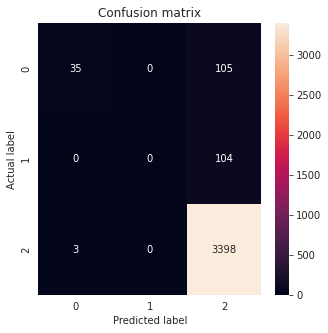

In [24]:
prediction = best_model.predict(rf_models2.test_ds)
prediction = pd.DataFrame(prediction)
prediction.columns = ["hetero", "homo", "singlet"]
prediction["prediction"] = prediction.apply(lambda row: rf_models2.class_checker(row), axis=1)

print("------------------------")
print(f"test class distribution: \n"
      f"{rf_models2.test_set['cell_type'].value_counts()}\n"
      f"\n"
      f"prediction class distribution:\n"
      f"{prediction['prediction'].value_counts()}")

rf_models2.plot_cm(rf_models2.test_set["cell_type"], prediction["prediction"])

In [17]:
mod.get_best_models

AttributeError: 'RandomForestModel' object has no attribute 'get_best_models'

In [18]:
best_params = rf_models2.models["hp_tuning_random_search"]["tuner"].get_best_hyperparameters()[0]

In [11]:
best = mod.get_best_models(1)[0]

AttributeError: 'RandomForestModel' object has no attribute 'get_best_models'

In [12]:
best

In [ ]:
best.

In [122]:
rf_models.add_new_model(model_name="model_4", params=params_v3)

/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/klumpi/Uni/courses/MLRegGenomics/doubletdetection/venv/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


add_new_model:
train
parameter supplied
Random Forest model...
Use /tmp/tmp4ldtanc_ as temporary training directory
{'adapt_bootstrap_size_ratio_for_maximum_training_duration': False, 'allow_na_conditions': False, 'bootstrap_size_ratio': 1.0, 'bootstrap_training_dataset': True, 'categorical_algorithm': 'RANDOM', 'categorical_set_split_greedy_sampling': 0.1, 'categorical_set_split_max_num_items': -1, 'categorical_set_split_min_item_frequency': 1, 'compute_oob_performances': True, 'compute_oob_variable_importances': False, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'honest': False, 'honest_fixed_separation': False, 'honest_ratio_leaf_examples': 0.5, 'in_split_min_examples_check': True, 'keep_non_leaf_label_distribution': True, 'max_depth': 16, 'max_num_nodes': 1000, 'maximum_model_size_in_memory_in_bytes': -1.0, 'maximum_training_duration_seconds': -1.0, 'min_examples': 5, 'missing_value_policy': 'GLOBAL_IMPUTATION', 'num_candidate_attributes': 0, 'num_candidate_attributes_ratio': -1.0, 'n

In [123]:
rf_models.train_model("model_4")

training model: model_4


[INFO kernel.cc:1176] Loading model from path /tmp/tmp4ldtanc_/model/ with prefix 9d85e10b50254b38
[INFO abstract_model.cc:1248] Engine "RandomForestGeneric" built
[INFO kernel.cc:1022] Use fast generic engine


compiling model


4/4 [==============================] - 3s 428ms/step
------------------------
test class distribution: 
singlet    3363
hetero      128
homo        114
Name: cell_type, dtype: int64

prediction class distribution:
singlet    3527
hetero       77
homo          1
Name: prediction, dtype: int64


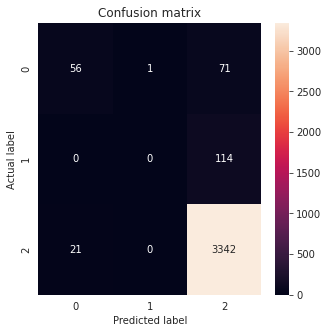

In [124]:
pred = rf_models.predict("model_4")

In [7]:
def filter_uniform_cols(data):
    nunique = data.nunique()
    to_drop = nunique[nunique == 1].index
    data.drop(to_drop, axis=1, inplace=True)
    return data